# DRAFT OF THIS IS FOR GOM2021 ONLY
Inputs: cdom files 
outputs: spectra.csv, outputs.csv, fig.csv
        
    Hanna Bridgham 
    last edited 07/31/2023
    

## PART 1: QA/QC

Loading data and checking for issues 

In [1]:
#LOAD REQUIERD PACKAGES 
import os # OS library 
import pandas as pd #the csv reading library 
import matplotlib.pyplot as plt #the ploting library 
import glob #to get file names 

from scipy.interpolate import PchipInterpolator # Interpolator 
import numpy as np 
from scipy.optimize import curve_fit 
from scipy.optimize import minimize 
import re


NOTES ON COMPLETED WORK:


In [2]:
#chose group of files 
files = glob.glob(f'../Fellowships/IRL_GRF/TURB/Turb_2318_5.11.2023/*.txt')

#input info about run 
sample_type = 'WC'
station = '2318'
camp = 'TURB'
Dil_fac = "none"

files.sort() 
print('I have your files') 

save_name_1 = f'../Fellowships/IRL_GRF/CDOM/Figs/Spectra_corrections_{sample_type}_{camp}_{station}.png'
save_name_2 = f'../Fellowships/IRL_GRF/CDOM/Figs/Spectra_transforms_{sample_type}_{camp}_{station}.png'

save_name_3 = f'../Fellowships/IRL_GRF/CDOM/Spectra/spectra_{sample_type}_{camp}_{station}.csv' 
save_name_4 = f'../Fellowships/IRL_GRF/CDOM/Spectra/sprectra_baseline_corrected_{sample_type}_{camp}_{station}.csv' 
save_name_5 = f'../Fellowships/IRL_GRF/CDOM/Spectra/sprectra_pchip_baseline_corrected_{sample_type}_{camp}_{station}.csv' 
save_name_6 = f'../Fellowships/IRL_GRF/CDOM/Spectra/sprectra_pchip_{sample_type}_{camp}_{station}.csv'
save_name_7 = f'../Fellowships/IRL_GRF/CDOM/Outputs/CDOM_outputs_{sample_type}_{camp}_{station}.csv'

pathlength = .01
psu = 0

files

I have your files


['../Fellowships/IRL_GRF/TURB/Turb_2318_5.11.2023\\231801_Absorbance__0__33.txt',
 '../Fellowships/IRL_GRF/TURB/Turb_2318_5.11.2023\\231802_Absorbance__0__32.txt',
 '../Fellowships/IRL_GRF/TURB/Turb_2318_5.11.2023\\231803_Absorbance__0__31.txt',
 '../Fellowships/IRL_GRF/TURB/Turb_2318_5.11.2023\\231804_Absorbance__0__30.txt',
 '../Fellowships/IRL_GRF/TURB/Turb_2318_5.11.2023\\231805_Absorbance__0__29.txt',
 '../Fellowships/IRL_GRF/TURB/Turb_2318_5.11.2023\\231806_Absorbance__0__28.txt',
 '../Fellowships/IRL_GRF/TURB/Turb_2318_5.11.2023\\231807_Absorbance__0__26.txt',
 '../Fellowships/IRL_GRF/TURB/Turb_2318_5.11.2023\\231808_Absorbance__0__25.txt',
 '../Fellowships/IRL_GRF/TURB/Turb_2318_5.11.2023\\231809_Absorbance__0__24.txt',
 '../Fellowships/IRL_GRF/TURB/Turb_2318_5.11.2023\\231810_Absorbance__0__23.txt',
 '../Fellowships/IRL_GRF/TURB/Turb_2318_5.11.2023\\231811_Absorbance__0__22.txt',
 '../Fellowships/IRL_GRF/TURB/Turb_2318_5.11.2023\\231812_Absorbance__0__21.txt',
 '../Fellowships

In [3]:
#chose dilution factor labs 
if Dil_fac == 'none': 
    dil_fac = 1
elif Dil_fac == 'five':
    dil_fac = 5
elif Dil_fac == 'two':
    dil_fac = 2
elif Dil_fac == 'four':
    dil_fac = 4
elif Dil_fac == 'twenty':
    dil_fac = 20
elif Dil_fac == 'ten':
    dil_fac = 10
elif Dil_fac == 'forty':
    dil_fac = 40
elif Dil_fac == 'eighty':
    dil_fac = 80
else: 
    dil_fac = XXXX
    print("ERROR: Dilution factor is not right")

#chose axis labs 
if sample_type == 'WC': 
    ylimmin = -10
    ylimmax = 200
    ylimmin2 = -2
    ylimmax2 = 2
elif sample_type == 'WC_PW': 
    ylimmin = -10
    ylimmax = 200
    ylimmin2 = -2
    ylimmax2 = 2
elif sample_type == 'WC_RZ': 
    ylimmin = -10
    ylimmax = 200
    ylimmin2 = -2
    ylimmax2 = 2
elif sample_type == 'BC': 
    ylimmin = -1
    ylimmax = 20
    ylimmin2 = -.2
    ylimmax2 = .2
elif sample_type == 'PW': 
    ylimmin = -10
    ylimmax = 200
    ylimmin2 = -2
    ylimmax2 = 2
elif sample_type == 'RZ': 
    ylimmin = -10
    ylimmax = 200
    ylimmin2 = -2
    ylimmax2 = 2
else: 
    pathlength = XXXX
    print("ERROR: pathlength is not right")

In [4]:
# Replace 'your_file.txt' with the actual path to your text file
with open(files[0], 'r') as file:
    lines = file.readlines()
# Join the lines into a single string
header = ''.join(lines)

# Search for the line that starts with "Spectrometer: " and capture the ID that follows
match = re.search(r'Spectrometer:\s+(\w+)', header)

# If a match is found, print and save it
if match:
    spectrometer_id = match.group(1)
    print(f"Spectrometer ID: {spectrometer_id}")
else:
    print("No match found.")

if spectrometer_id == 'FLMS02459': 
    spec_used = "CDOM"
elif spectrometer_id == "FLMS12623": 
    spec_used = "Flame"
else: 
    print("no spec found")

if spec_used == "Flame": 
    wl_range = 751
    base_cor_min = 700 
    base_cor_max = 725 
elif spec_used == "CDOM": 
    wl_range = 523
    base_cor_min = np.nan 
    base_cor_max = np.nan 
else: 
    print("ERROR YOU DONT HAVE A SPEC FOR THIS")

Spectrometer ID: FLMS12623


In [5]:
#MANUAL OVERRIDE    
#pathlength = .50
#psu = 35X
#dil_fac = XX

print('Pathlenth: ', pathlength)
print('Wavelenth max: ', wl_range)
#print('Salinity: ', psu)
print('Dilution Factor: ', dil_fac)
print('Y limet maximun: ',ylimmax)

Pathlenth:  0.01
Wavelenth max:  751
Dilution Factor:  1
Y limet maximun:  200


In [6]:
#LOAD FILE
def open_files(name):
    # reads individual scan files
    df = pd.read_table(name, skiprows=14,names=['wl', 'abs'], index_col='wl')
    # extract ID from filename
    ID = name[:-4].split("\\")[1]
    # rename col name with ID
    df = df.rename(columns={'abs': ID})
    return df

def open_files_alt(name):
    # reads individual scan files
    with open(name, 'r') as f:
        lines = f.readlines()
    wl_line = lines[14].strip() 
    abs_ion_line = lines[15].strip()
    wl_names = wl_line.split('\t')
    abs_ion_names = abs_ion_line.split('\t')
    df = pd.read_table(name, skiprows=16, names=['wl', 'abs'])
    df['wl'] = wl_names
    df['abs'] = abs_ion_names[2:]
    df.index = df['wl']
    df = df.drop('wl', axis = 1)
    ID = name[:-4].split("\\")[1]
    # rename col name with ID
    df = df.rename(columns={'abs': ID})
    return df

#LOOP TRU FILES TO MAKE ONE EASY TO USE DATA FRAME 
#columns are scanns and rows are wavelths 

if station == "St.14" and sample_type == "WC": 
    frames = [open_files_alt(f) for f in files]
    df = pd.concat(frames, axis=1) # joins along cols  
    df = df.apply(pd.to_numeric, errors='coerce')  # This will convert non-numeric values to NaN
    df.index = pd.to_numeric(df.index, errors='coerce')
    print("alt used")
else: 
    frames = [open_files(f) for f in files]
    df = pd.concat(frames, axis=1) # joins along cols  

print("files loaded and the data frame is made")

files loaded and the data frame is made


## PART 2: CORRECTING THE DATA 

- Absorbace to absorption 

- Salinity coorection 

- Temprature correction 

### Absorbance to absortion

absortion = absorbance*(2.303/pathlength)

In [7]:
#Absorbance to Absortion
df_cl = df*(2.303/pathlength) # to avoid overwriting when reruning the cell

### Correct it for Dilition 

absortion = absortion*dilution factor 

In [8]:
#Absorbance to Absortion
df_dil = df_cl*(dil_fac) # to avoid overwriting when reruning the cell

### Salinity correction

graph showing the interprolated correction


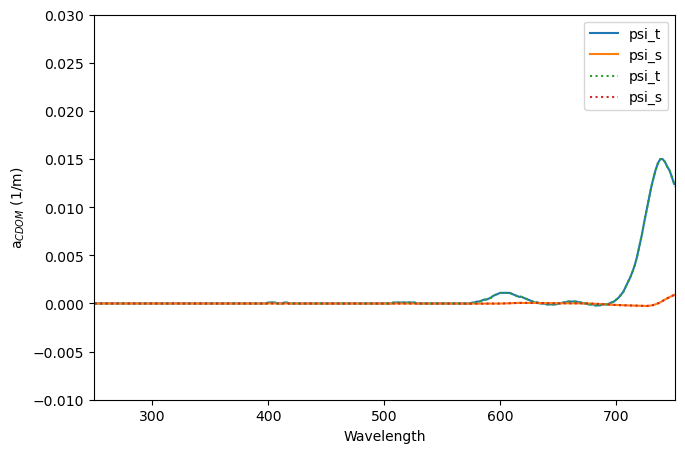

In [9]:
#HERE WE LOAD AND INTIGRATE THE CORRECTION VALUES 

#Load correction values 
df_c1 = df_dil
corr = pd.read_csv('../CDOM_DATA/sal_temp_corr.csv')
corr.rename(columns={'wl_nm':'wl'}, inplace=True)
corr.set_index('wl', inplace=True)

# Interpolate corr curve to measured wl 
x = corr.index # corr wl
xi = df_c1[250:wl_range].index # measured wl, no need to overwrite

#pchip temp  
y = corr['psi_t'] 
pchip_t = PchipInterpolator(x, y, axis=1)
psi_t = pchip_t(xi) 

#pchip salt 
y = corr['psi_s'] 
pchip_s = PchipInterpolator(x, y, axis=1)
psi_s = pchip_s(xi)

# to dataframe
correction = pd.DataFrame({'psi_t': psi_t, 'psi_s':psi_s}, index=xi)

# Plot
fig, ax = plt.subplots(figsize=(7.5,5))
corr.plot(ax=ax)
correction.plot(ls=':',ax=ax)
ax.set_ylim(-.01,.03)
ax.set_xlim(250,wl_range)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")
#ax.get_legend().remove() 

if corr.mean().mean()/correction.mean().mean() > .8: 
    print('graph showing the interprolated correction')
else:
    print('SOMETHING IS WRONG!')
    print('interprolated correction mean is less then 80%')
    print((corr.mean().mean()/correction.mean().mean())*100)

### Salinity correction
from sullivan 2006 

abs = abs_mesured - psu*psi_s 

In [10]:
#HERE WE CORRECT FOR SALINITY 
#from sullivan 2006 

#a = a_m - psu*psi_s 

nacl = 31.56

Frames = []
for columnName in df_dil:
    Sample_ID = re.findall(r'\d{6}', columnName)
    Sample_ID = int(Sample_ID[0]) if Sample_ID else None
    selected_data = df_dil.loc[250:wl_range, columnName]
    col_cs = selected_data.sub(psu*correction['psi_s'], axis=0)
    Frames.append(col_cs)

df_cs = pd.concat(Frames, axis=1, ignore_index=False)
New_Labels = df_dil.columns
df_cs.columns = New_Labels

sal_corr_per = ((df_dil.mean().mean()-df_dil.mean().mean())/(df_cs.mean().mean()+df_dil.mean().mean())/2)*100

print("Min val of clean data:",df_cl.min().min()) 
print("Min val of dilution data:",df_dil.min().min()) 
print("Min val of salinity Corr:",df_cs.min().min()) 
print(sal_corr_per, "% differance in mean values for dilution to sal corrected")

if df_cs.mean().mean()/df_dil.mean().mean() > .8: 
    print('graph showing salinity corrected data')
else:
    print('SOMETHING IS WRONG!')
    print('interprolated correction mean is less then 80%')
    print((df_cs.mean().mean()/df_cl.mean().mean())*100)

Min val of clean data: -578.81299
Min val of dilution data: -578.81299
Min val of salinity Corr: -11.30773
0.0 % differance in mean values for dilution to sal corrected
SOMETHING IS WRONG!
interprolated correction mean is less then 80%
20.628221555545142


### Temperature correction
from sullivan 2006 

abs = abs_mesured - temp*psi_t 

In [11]:
#HERE WE DEFINE THE END AND DEFINE THE FUNTIONS 

#define the end section 
df_700 = df_cs[700:750] # df_cs is clean, abs and sal corrct aplied
temp_cor_700 = correction[700:750]['psi_t']       

#define temp correction 
def temp_cor(temp,
             c_abs, # the column
             t_cor= correction['psi_t']# the correction
            ):
    return (c_abs-t_cor*temp)

# this is the function to minimize the root mean squared 
def rmse(temp, col_abs):
    cor = temp_cor(temp, c_abs=col_abs, t_cor=correction[700:750]['psi_t'])
    col_abs_mean = col_abs.mean()
    col_resid = cor-col_abs_mean
    diff = np.sqrt(np.mean(col_resid**2))
    return  diff

print('funtions are defined')

funtions are defined


In [12]:
#HERE WE DO THE TEMP CORRECTION FOR ALL THE DATA 
# minimization
#maybe play with bonds for improvement
#minimize(rmse, temp0, df_700.iloc[:,0], bounds=(min,max))

coln = np.arange(0, len(df_700.columns), 1, dtype=int)
Frames = []
frames = []

for col in coln:
    res = minimize(rmse, 0, df_700.iloc[:,col])
    col_ct = temp_cor(res.x, df_cs.iloc[:,col])
    Frames.append(col_ct)
    temp_val = res.x[0]
    col_ct_resid = col_ct[700:750]-col_ct[700:750].mean()
    temp_rmse = np.sqrt(np.mean(col_ct_resid**2))
    dict = {'temp_val':[temp_val], 
           'temp_rmse':[temp_rmse]}
    diff = pd.DataFrame(dict)
    frames.append(diff) #save the inportant outputs 

df_ct = pd.concat(Frames, axis=1, ignore_index=False)
New_Labels = df_cs.columns
df_ct.columns = New_Labels

outputs = pd.concat(frames, axis=0, ignore_index=False)
New_Labels = df_cs.columns
outputs.index = list(New_Labels)

print("")
temp_corr_per = ((df_cs.mean().mean()-df_ct.mean().mean())/(df_cs.mean().mean()+df_ct.mean().mean())/2)*100
print(temp_corr_per, "% differance in mean values")
print("")

temp_cuttoff = 30
max_temp = outputs["temp_val"].max()
temp_cout = abs(outputs["temp_val"]).gt(30).sum()
rmse_cutoff = 10
max_rmse = outputs["temp_rmse"].max()
rmse_cout = outputs["temp_rmse"].gt(rmse_cutoff).sum()

if max_rmse > rmse_cutoff: 
    print("WARNING")
    print("RMSE PROBLEM")
    print("")
    print("max rmse:", max_rmse)
    print("rmse cuttoff:", rmse_cutoff)
    print(rmse_cout, 'fits were above the cuttoff')
    print("Min val of sal Corr:",df_cs.min().min()) 
    print("Min val of temo Corr:",df_ct.min().min()) 
if max_temp > temp_cuttoff: 
    print("WARNING")
    print("TEMP PROBLEM")
    print("")
    print("max temp:", max_temp)
    print("temp cuttoff:", temp_cuttoff)
    print(temp_cout, 'fits were above the cuttoff')
    print("Min val of sal Corr:",df_cs.min().min()) 
    print("Min val of temo Corr:",df_ct.min().min()) 
else: 
    print('the run was a success! :) ')


0.06746836727121852 % differance in mean values

the run was a success! :) 


### baceline correction

just subtract the mean from 700 to 725

In [13]:
#HERE WE DO THE BASLINE CORRECTION AND SAVE THE CORECTION AS 'bcorr'

bcorr = df_ct[base_cor_min:base_cor_max].mean(axis=0) # 486:537 is 675 to 725 nm and this line takes the average 
df_bc = df_ct[:] - bcorr # here we correct the data by that average

outputs['mean_700_725'] = bcorr
print("")
print("mean value for the baceline:", outputs['mean_700_725'].mean())
print("min value for the baceline:", outputs['mean_700_725'].min())
print("max value for the baceline:", outputs['mean_700_725'].max())
print("")
print("Succcess")


mean value for the baceline: 0.0006775875216610834
min value for the baceline: -1.0704571031452792
max value for the baceline: 0.4929967147678926

Succcess


### Compare the data 

look at the graphs to see how the corrections changed the data

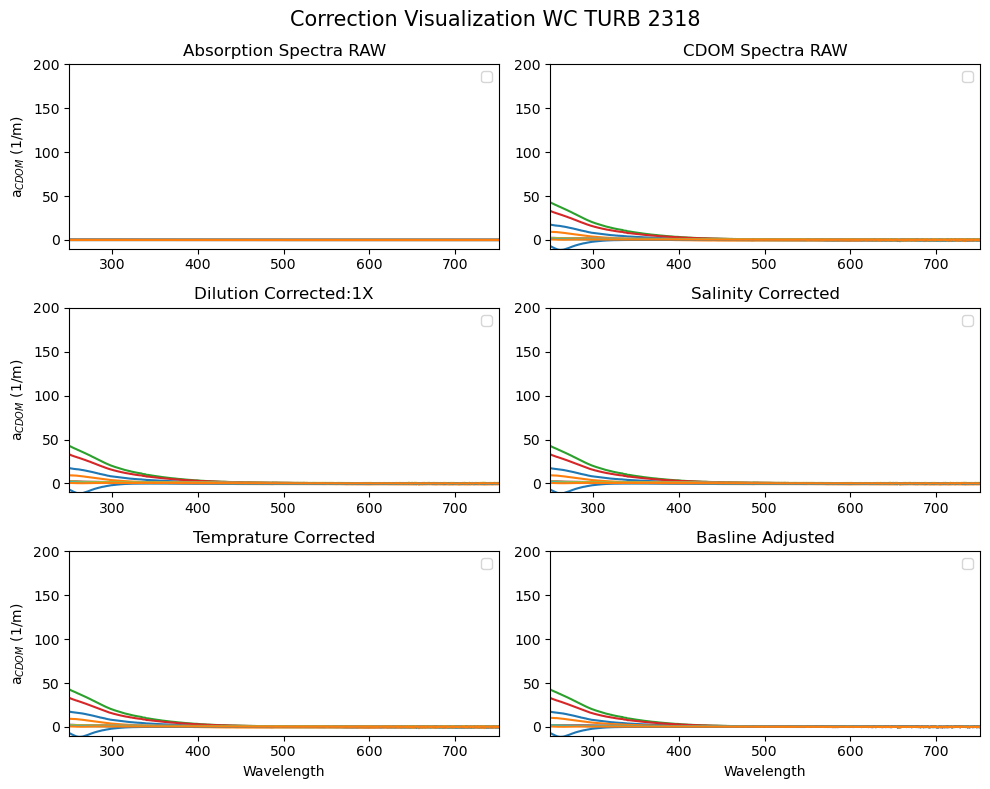

In [14]:
#graph the diffrent transforms

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 8)) 

df.plot(ax=axs[0,0])
df_cl.plot(ax=axs[0,1])
df_dil.plot(ax=axs[1,0])
df_cs.plot(ax=axs[1,1])
df_ct.plot(ax=axs[2,0])
df_bc.plot(ax=axs[2,1])

axs[0,0].set_title("Absorption Spectra RAW")
axs[0,1].set_title("CDOM Spectra RAW")
axs[1,0].set_title(f"Dilution Corrected:{dil_fac}X")
axs[1,1].set_title("Salinity Corrected")
axs[2,0].set_title("Temprature Corrected")
axs[2,1].set_title("Basline Adjusted")

axs[0,0].set_ylim(ylimmin,ylimmax)
axs[0,1].set_ylim(ylimmin,ylimmax)
axs[1,1].set_ylim(ylimmin,ylimmax)
axs[1,0].set_ylim(ylimmin,ylimmax)
axs[2,1].set_ylim(ylimmin,ylimmax)
axs[2,0].set_ylim(ylimmin,ylimmax)

axs[0,0].set_xlim(250,wl_range)
axs[0,1].set_xlim(250,wl_range)
axs[1,1].set_xlim(250,wl_range)
axs[1,0].set_xlim(250,wl_range)
axs[2,1].set_xlim(250,wl_range)
axs[2,0].set_xlim(250,wl_range)

axs[2,0].set_xlabel("Wavelength")
axs[2,1].set_xlabel("Wavelength")
axs[1,0].set_xlabel("")
axs[1,1].set_xlabel("")
axs[0,0].set_xlabel("")
axs[0,1].set_xlabel("")

axs[0,0].set_ylabel("a$_{CDOM}$ (1/m)")
axs[1,0].set_ylabel("a$_{CDOM}$ (1/m)")
axs[2,0].set_ylabel("a$_{CDOM}$ (1/m)")


axs[0,1].set_ylabel("")
axs[1,1].set_ylabel("")
axs[2,1].set_ylabel("")


axs[0,0].legend("")
axs[0,1].legend("")
axs[1,1].legend("")
axs[1,0].legend("")
axs[2,0].legend("")
axs[2,1].legend("")


fig.suptitle(f'Correction Visualization {sample_type} {camp} {station}', size = 15)
fig.set_facecolor('w')
plt.tight_layout()

#save plot 
plt.savefig(save_name_1)

### PART 2: REGRESSIONS

I need an output table for each sampling event with the sample number

we will get this with 2 regression methods 

there are two ways we are going to calculate the spectral slopes 
1. Single exponential (SEM) where: $A(g)=Ae^{slope}$
2. Hyperbolic (HM) where: $A(g)=A(\frac{wl}{532})^{slope}$
2. Power Law (PL) where:

corresponding parameters - slopes 
                the spectral slope of 275 to 295
                the spectral slope of 350 to 400
                the spectral slope of 275 to 700

corresponding parameters - slop ratios
                spectral ratio of slope 275 to 295 to slope of 350 to 400


In [15]:
#DEFINE EXPONENTAL REGRESSION 
#A(g)=Ae^slope
def exp_equation(x, a, s, b):
    return a * np.exp(-s * x) + b

#DEFINE HYPERBOLIC REGRESSION 
#A(g)=A(wl/532)^slope
def hyp_equation(x, a, s, b):
    return a * ((x/532)**-s) + b

#DEFINE POWER LAW REGRESSION 
#going to do that in the future 

#add a wl col so we can use it in the rags  
#df_final["wl"] = df_final.index

print("the functions are set")

the functions are set


In [16]:
#SELECT THE corrected data and the basline adjusted data

#corrected 
df_final = df_ct
df_final["wl"] = df_final.index

#basline adjusted
df_final_bc = df_bc
df_final_bc["wl"] = df_final_bc.index

In [17]:
#HERE DO THE EXPONENTAL REGRESSION FOR ALL SAMPLES 
#Corrected Data 

Frames = []
maxfev = 10000000
for (columnName, columnData) in df_final.items():
    col = columnName
    #get the x and y values for all the slope intervals we want 
    ydata_s700 = df_final[(df_final['wl']>=275) & (df_final['wl']<=700)][col]
    xdata_s700 = df_final[(df_final['wl']>=275) & (df_final['wl']<=700)]['wl']
    ydata_s700 = np.asarray(ydata_s700, dtype=float).ravel()
    xdata_s700 = np.asarray(xdata_s700, dtype=float).ravel()
    ydata_s295 = df_final[(df_final['wl']>=275) & (df_final['wl']<=295)][col]
    xdata_s295 = df_final[(df_final['wl']>=275) & (df_final['wl']<=295)]['wl']
    ydata_s295 = np.asarray(ydata_s295, dtype=float).ravel()
    xdata_s295 = np.asarray(xdata_s295, dtype=float).ravel()
    ydata_s350 = df_final[(df_final['wl']>=350) & (df_final['wl']<=400)][col]
    xdata_s350 = df_final[(df_final['wl']>=350) & (df_final['wl']<=400)]['wl']
    ydata_s350 = np.asarray(ydata_s350, dtype=float).ravel()
    xdata_s350 = np.asarray(xdata_s350, dtype=float).ravel()
    
    #set some innital guesses to the curve fit 
    pams_700 = (15, .001, 0)
    pams_295 = (10, .001, 0)
    pams_350 = (10, .001, 0)
    
    #regression exp_equation 275 to 700
    params, cv = curve_fit(exp_equation, xdata_s700, ydata_s700, p0=pams_700, maxfev=maxfev)
    a, s, b = params
    
    #get the valuse for exp_equation 275 to 700 and calcuate rSquared
    squaredDiffs = np.square(ydata_s700 - exp_equation(xdata_s700, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s700 - np.mean(ydata_s700))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_275_700 = rSquared
    ss_275_700 = s
    
    #get the waveleths we need
    abs_254 = exp_equation(252, a, s, b)
    abs_280 = exp_equation(280, a, s, b)
    abs_320 = exp_equation(320, a, s, b)
    abs_350 = exp_equation(350, a, s, b)
    abs_412 = exp_equation(412, a, s, b)
    abs_440 = exp_equation(440, a, s, b)
    
    #regression exp_equation 275 to 295
    params, cv = curve_fit(exp_equation, xdata_s295, ydata_s295, p0=pams_295, maxfev=maxfev)
    a, s, b = params
    
    #get the valuse for exp_equation 270 to 295 and calcuate rSquared
    squaredDiffs = np.square(ydata_s295 - exp_equation(xdata_s295, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s295 - np.mean(ydata_s295))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_275_295 = rSquared
    ss_275_295 = s
    
    #regression exp_equation 350 to 400
    params, cv = curve_fit(exp_equation, xdata_s350, ydata_s350, p0=pams_350, maxfev=maxfev)
    a, s, b = params
    
    #get the valuse for exp_equation 350 to 400 and calcuate rSquared
    squaredDiffs = np.square(ydata_s350 - exp_equation(xdata_s350, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s350 - np.mean(ydata_s350))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_350_400 = rSquared
    ss_350_400 = s 
    
    #get the spectral ratio 
    sr = ss_275_295 / ss_350_400
    
    dict = {'sample':[columnName],
        'ss_275_700_sem':[ss_275_700],
        'ss_275_295_sem':[ss_275_295],
        'ss_350_400_sem':[ss_350_400],
        'R2_275_700_sem':[R2_275_700],
        'R2_275_295_sem':[R2_275_295],
        'R2_350_400_sem':[R2_350_400],
        'SR_sem':[sr]}
    ss_outs = pd.DataFrame(dict)
    ss_outs = ss_outs.set_index('sample', drop=True)
    Frames.append(ss_outs)

ss_outs_sem = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
ss_outs_sem = ss_outs_sem.drop('wl')

print("Single exponential done! yay!")

Single exponential done! yay!


In [18]:
#HERE DO THE HYPERBOLIC REGRESSION FOR ALL SAMPLES 
Frames = []
maxfev = 10000000
for (columnName, columnData) in df_final.items():
    col = columnName
    #get the x and y values for all the slope intervals we want 
    #get the x and y values for all the slope intervals we want 
    ydata_s700 = df_final[(df_final['wl']>=275) & (df_final['wl']<=700)][col]
    xdata_s700 = df_final[(df_final['wl']>=275) & (df_final['wl']<=700)]['wl']
    ydata_s700 = np.asarray(ydata_s700, dtype=float).ravel()
    xdata_s700 = np.asarray(xdata_s700, dtype=float).ravel()
    ydata_s295 = df_final[(df_final['wl']>=275) & (df_final['wl']<=295)][col]
    xdata_s295 = df_final[(df_final['wl']>=275) & (df_final['wl']<=295)]['wl']
    ydata_s295 = np.asarray(ydata_s295, dtype=float).ravel()
    xdata_s295 = np.asarray(xdata_s295, dtype=float).ravel()
    ydata_s350 = df_final[(df_final['wl']>=350) & (df_final['wl']<=400)][col]
    xdata_s350 = df_final[(df_final['wl']>=350) & (df_final['wl']<=400)]['wl']
    ydata_s350 = np.asarray(ydata_s350, dtype=float).ravel()
    xdata_s350 = np.asarray(xdata_s350, dtype=float).ravel()
    
    #set some innital guesses to the curve fit 
    pams_700 = (.001, 11, 0)
    pams_295 = (1, 0, 1)
    pams_350 = (1, 1, 1)
    
    maxfev = 1000000
    
    #regression exp_equation 275 to 700
    params, cv = curve_fit(hyp_equation, xdata_s700, ydata_s700, p0=pams_700, maxfev=maxfev)
    a, s, b = params
    
    #print out for exp_equation 275 to 700 and calcuate rSquared
    squaredDiffs = np.square(ydata_s700 - hyp_equation(xdata_s700, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s700 - np.mean(ydata_s700))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_275_700 = rSquared
    ss_275_700 = s
    
    #get the waveleths we need
    abs_254 = hyp_equation(252, a, s, b)
    abs_280 = hyp_equation(280, a, s, b)
    abs_320 = hyp_equation(320, a, s, b)
    abs_350 = hyp_equation(350, a, s, b)
    abs_412 = hyp_equation(412, a, s, b)
    abs_440 = hyp_equation(440, a, s, b)
    
    #regression exp_equation 275 to 295
    params, cv = curve_fit(hyp_equation, xdata_s295, ydata_s295, p0=pams_295, maxfev=maxfev)
    a, s, b = params
    
    #print out for exp_equation 270 to 295 and calcuate rSquared
    squaredDiffs = np.square(ydata_s295 - hyp_equation(xdata_s295, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s295 - np.mean(ydata_s295))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_275_295 = rSquared
    ss_275_295 = s
    
    #regression exp_equation 350 to 400
    params, cv = curve_fit(hyp_equation, xdata_s350, ydata_s350, p0=pams_350, maxfev=maxfev)
    a, s, b = params
    
    #print out for exp_equation 350 to 400 and calcuate rSquared
    squaredDiffs = np.square(ydata_s350 - hyp_equation(xdata_s350, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s350 - np.mean(ydata_s350))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_350_400 = rSquared
    ss_350_400 = s 
    
    #get the spectral ratio 
    sr = ss_275_295 / ss_350_400
    
    dict = {'sample':[columnName],
        'ss_275_700_hm':[ss_275_700],
        'ss_275_295_hm':[ss_275_295],
        'ss_350_400_hm':[ss_350_400],
        'R2_275_700_hm':[R2_275_700],
        'R2_275_295_hm':[R2_275_295],
        'R2_350_400_hm':[R2_350_400],
        'SR_hm':[sr]}
    ss_outs = pd.DataFrame(dict)
    ss_outs = ss_outs.set_index('sample', drop=True)
    Frames.append(ss_outs)

ss_outs_hm = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
ss_outs_hm = ss_outs_hm.drop('wl')

print("Hyperbolic done! yay!")

Hyperbolic done! yay!


#HERE DO THE HYPERBOLIC REGRESSION FOR ALL SAMPLES 
Frames = []
maxfev = 10000000
for (columnName, columnData) in df_final.iteritems():
    col = columnName

    R2_275_700 = np.nan
    ss_275_700 = np.nan
    
    #get the waveleths we need
    abs_254 = np.nan
    abs_280 = np.nan
    abs_320 = np.nan
    abs_350 = np.nan
    abs_412 = np.nan
    abs_440 = np.nan
    
    R2_275_295 = np.nan
    ss_275_295 = np.nan
    
    #print out for exp_equation 350 to 400 and calcuate rSquared
    R2_350_400 = np.nan
    ss_350_400 = np.nan
    
    #get the spectral ratio 
    sr = np.nan
    
    dict = {'sample':[columnName],
        'ss_275_700_hm':[ss_275_700],
        'ss_275_295_hm':[ss_275_295],
        'ss_350_400_hm':[ss_350_400],
        'R2_275_700_hm':[R2_275_700],
        'R2_275_295_hm':[R2_275_295],
        'R2_350_400_hm':[R2_350_400],
        'SR_hm':[sr]}
    ss_outs = pd.DataFrame(dict)
    ss_outs = ss_outs.set_index('sample', drop=True)
    Frames.append(ss_outs)

ss_outs_hm = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
ss_outs_hm = ss_outs_hm.drop('wl')

print("Hyperbolic done! yay!")

In [19]:
#HERE WE TEST TO MAKE SURE THE R SQAURED IS GOOD 
#this will let us know if something is wrong and where

#make the outputs an easy to use data frame 
ss_outs = pd.concat([ss_outs_sem, ss_outs_hm, outputs], axis = 1, ignore_index=False)

#set the R2 level you want 
R_level = .8
col_note_2 = f'R sqared cuttoff: {R_level}'
col_note_2

#print out the summary stats 
min_1 = ss_outs['R2_275_700_sem'].min()
min_2 = ss_outs['R2_275_295_sem'].min()
min_3 = ss_outs['R2_350_400_sem'].min()
min_4 = ss_outs['R2_275_700_hm'].min()
min_5 = ss_outs['R2_275_295_hm'].min()
min_6 = ss_outs['R2_350_400_hm'].min()

filter_col = [col for col in ss_outs if col.startswith('R2')]

if 1 < 2:
    print("")
    print("the R2 cuttoff was", R_level)
if min_1 < R_level: 
    print("")
    print("bad fits in Exponential 275 to 700:", ss_outs["R2_275_700_sem"].lt(R_level).sum())
if min_2 < R_level:
    print("")
    print("bad fits in Exponential 275 to 275:", ss_outs["R2_275_295_sem"].lt(R_level).sum())
if min_3 < R_level:
    print("")
    print("bad fits in Exponential 350 to 400:", ss_outs["R2_350_400_sem"].lt(R_level).sum())
if min_4 < R_level:
    print("")
    print("bad fits in Hyperbolic 275 to 700:", ss_outs["R2_275_700_hm"].lt(R_level).sum())
if min_5 < R_level:
    print("")
    print("bad fits in Hyperbolic 275 to 275:", ss_outs["R2_275_295_hm"].lt(R_level).sum())
if min_6 < R_level:
    print("")
    print("bad fits in Hyperbolic 350 to 400:", ss_outs["R2_350_400_hm"].lt(R_level).sum())
if ss_outs[filter_col].gt(R_level).sum().sum() > ss_outs[filter_col].lt(R_level).sum().sum():
    print("")
    print(ss_outs[filter_col].gt(R_level).sum().sum(),": fits came out good")
    print(ss_outs[filter_col].lt(R_level).sum().sum(),": fits came out bad")
    print("")
    print("Succsess:", ss_outs[filter_col].gt(R_level).sum().sum()/ss_outs[filter_col].gt(-1000).sum().sum()*100,"%" )
else: 
    print("")
    print("SOMETHING HAS GONE WRONG")
    print("")
    print("fits came out good")
    print(ss_outs[filter_col].gt(R_level).sum())
    print("TOTAL GOOD:", ss_outs[filter_col].gt(R_level).sum().sum())
    print("")
    print("fits came out bad")
    print(ss_outs[filter_col].lt(R_level).sum())
    print("TOTAL BAD:", ss_outs[filter_col].lt(R_level).sum().sum())



the R2 cuttoff was 0.8

bad fits in Exponential 275 to 700: 1

bad fits in Exponential 275 to 275: 1

bad fits in Exponential 350 to 400: 9

bad fits in Hyperbolic 275 to 700: 1

bad fits in Hyperbolic 275 to 275: 1

bad fits in Hyperbolic 350 to 400: 11

108 : fits came out good
24 : fits came out bad

Succsess: 81.81818181818183 %


### MAKE THE FINAL PRODUCTS 

corresponding parameters 
1. cdom abs at 254
2. cdom abs at 320
3. cdom abs at 350
4. cdom abs at 412
5. cdom abs at 440 
6. cdom abs at 700

In [20]:
#HERE WE MAKE A COPY INTERPROLATED DATA SET
x = df_final.index
coln = np.arange(0, len(df_final.columns), 1, dtype=int)

Frames = []
frames = []

for col in coln:
    y = df_final.iloc[:,col]
    pchip_col = PchipInterpolator(x, y, axis=1)
    xi = np.arange(250,wl_range,1)
    yi = pchip_col(xi)
    d = {'abs': yi}
    pchip_c = pd.DataFrame(d, index = xi)
    Frames.append(pchip_c)

df_pchip = pd.concat(Frames, axis=1, ignore_index=False)
New_Labels = df_final.columns
df_pchip.columns = New_Labels
print("the interproated data set for each scan is created")

#HERE WE MAKE A COPY OF THE DATA THAT IS VERTICAL SO JB LIKES IT
abs_data_pchip = df_pchip.transpose(copy=False)
abs_data = df_final.transpose(copy=False)
print("the transpose data sets are created")

#LETS ADD THOSE IMPORTANT WAVELEGNTHS TO THE OUTOUTS TABEL 
abs_254 = df_pchip.iloc[4:5,]
abs_254 = abs_254.transpose(copy=False)
abs_320 = df_pchip.iloc[70:71,]
abs_320 = abs_320.transpose(copy=False)
abs_350 = df_pchip.iloc[100:101,]
abs_350 = abs_350.transpose(copy=False)
abs_412 = df_pchip.iloc[162:163,]
abs_412 = abs_412.transpose(copy=False)
abs_440 = df_pchip.iloc[190:191,]
abs_440 = abs_440.transpose(copy=False)
abs_700 = df_pchip.iloc[450:451,]
abs_700 = abs_700.transpose(copy=False)

abs_out = pd.concat([abs_254, abs_320, abs_350, abs_412, abs_440, abs_700], axis=1)
abs_out = abs_out.add_prefix('acdom_')
outputs_scan = pd.concat([ss_outs, abs_out], axis = 1)
outputs_scan = outputs_scan.drop('wl')

print("")
print("Yay! we have the final outputs for the corrected data")

the interproated data set for each scan is created
the transpose data sets are created

Yay! we have the final outputs for the corrected data


In [21]:
#HERE WE MAKE A COPY INTERPROLATED DATA SET
if spec_used == "Flame": 
    x = df_final_bc.index
    coln = np.arange(0, len(df_final_bc.columns), 1, dtype=int)

    Frames = []
    frames = []

    for col in coln:
        y = df_final_bc.iloc[:,col]
        pchip_col = PchipInterpolator(x, y, axis=1)
        xi = np.arange(250,wl_range,1)
        yi = pchip_col(xi)
        d = {'abs': yi}
        pchip_c = pd.DataFrame(d, index = xi)
        Frames.append(pchip_c)

    df_pchip_bc = pd.concat(Frames, axis=1, ignore_index=False)
    New_Labels = df_final_bc.columns
    df_pchip_bc.columns = New_Labels
    print("the interproated data set for each scan is created")

    #HERE WE MAKE A COPY OF THE DATA THAT IS VERTICAL SO JB LIKES IT
    abs_data_pchip_bc = df_pchip_bc.transpose(copy=False)
    abs_data_bc = df_final_bc.transpose(copy=False)
    print("the transpose data sets are created")

    #LETS ADD THOSE IMPORTANT WAVELEGNTHS TO THE OUTOUTS TABEL 
    abs_254 = df_pchip.iloc[4:5,]
    abs_254 = abs_254.transpose(copy=False)
    abs_320 = df_pchip.iloc[70:71,]
    abs_320 = abs_320.transpose(copy=False)
    abs_350 = df_pchip.iloc[100:101,]
    abs_350 = abs_350.transpose(copy=False)
    abs_412 = df_pchip.iloc[162:163,]
    abs_412 = abs_412.transpose(copy=False)
    abs_440 = df_pchip.iloc[190:191,]
    abs_440 = abs_440.transpose(copy=False)
    abs_700 = df_pchip.iloc[450:451,]
    abs_700 = abs_700.transpose(copy=False)

    abs_out = pd.concat([abs_254, abs_320, abs_350, abs_412, abs_440, abs_700], axis=1)
    abs_out = abs_out.add_prefix('acdom_')
    abs_out = abs_out.add_suffix('_bc')
    outputs_scan = pd.concat([outputs_scan, abs_out], axis = 1)
    outputs_scan = outputs_scan.drop('wl')

    print("")
    print("Yay! we have the final outputs for the basline ajusted data")
else: 
    print("")
    print("No worries! this was the CDOM speck")


the interproated data set for each scan is created
the transpose data sets are created

Yay! we have the final outputs for the basline ajusted data


### Summary 

In [22]:
#take out the wavelenths 
if spec_used == "Flame": 
    df_final = df_final.drop('wl', axis=1)
    df_final_bc = df_final_bc.drop('wl', axis=1)
    df_pchip = df_pchip.drop('wl', axis=1)
    df_pchip_bc = df_pchip_bc.drop('wl', axis=1)
else: 
    df_final = df_final.drop('wl', axis=1)
    df_pchip = df_pchip.drop('wl', axis=1)

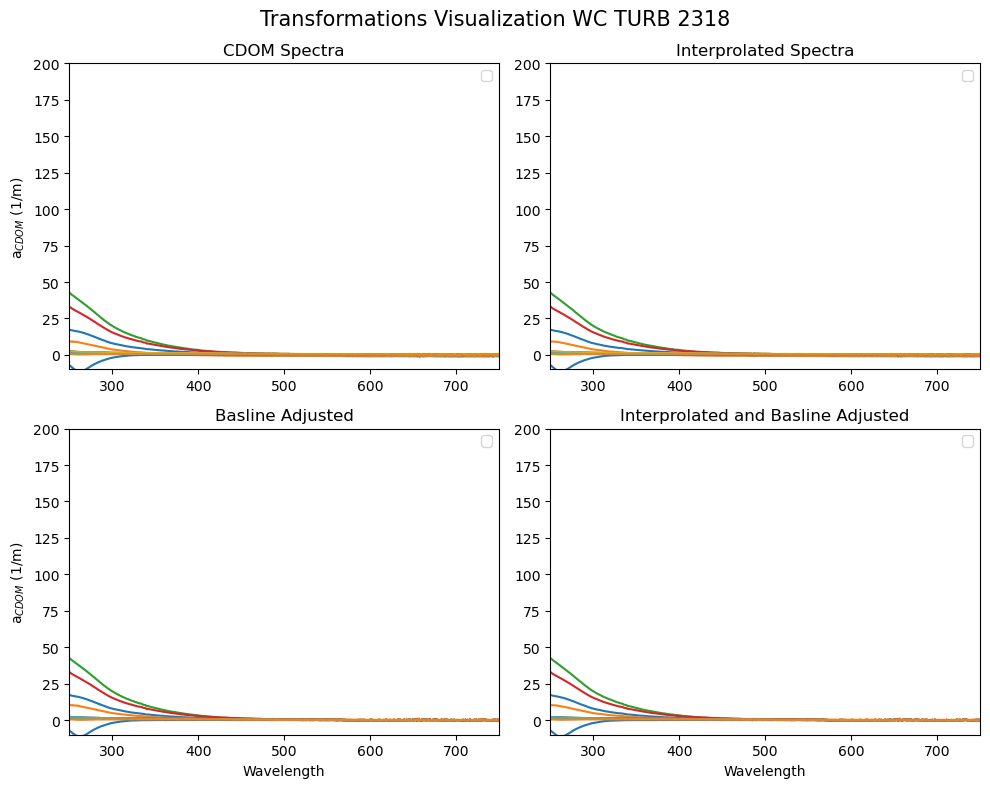

In [23]:
#graph the diffrent transforms
if spec_used == "Flame": 
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8)) 

    df_final.plot(ax=axs[0,0])
    df_final_bc.plot(ax=axs[1,0])
    df_pchip.plot(ax=axs[0,1])
    df_pchip_bc.plot(ax=axs[1,1])

    axs[0,0].set_title("CDOM Spectra")
    axs[0,1].set_title("Interprolated Spectra")
    axs[1,0].set_title("Basline Adjusted")
    axs[1,1].set_title("Interprolated and Basline Adjusted")
    
    axs[0,0].set_ylim(ylimmin,ylimmax)
    axs[0,1].set_ylim(ylimmin,ylimmax)
    axs[1,1].set_ylim(ylimmin,ylimmax)
    axs[1,0].set_ylim(ylimmin,ylimmax)

    axs[0,0].set_xlim(250,750)
    axs[0,1].set_xlim(250,750)
    axs[1,1].set_xlim(250,750)
    axs[1,0].set_xlim(250,750)
    
    axs[1,0].set_xlabel("Wavelength")
    axs[1,1].set_xlabel("Wavelength")

    axs[0,0].set_xlabel("")
    axs[0,1].set_xlabel("")

    axs[0,0].set_ylabel("a$_{CDOM}$ (1/m)")
    axs[1,0].set_ylabel("a$_{CDOM}$ (1/m)")

    axs[0,1].set_ylabel("")
    axs[1,1].set_ylabel("")

    axs[0,0].legend("")
    axs[0,1].legend("")
    axs[1,1].legend("")
    axs[1,0].legend("")

    fig.suptitle(f'Transformations Visualization {sample_type} {camp} {station}', size = 15)
    fig.set_facecolor('w')
    plt.tight_layout()

    #save plot 
    plt.savefig(save_name_2)

else: 
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4)) 

    df_final.plot(ax=axs[0])
    df_pchip.plot(ax=axs[1])

    axs[0].set_title("CDOM Spectra")
    axs[1].set_title("Interprolated Spectra")
    
    axs[0].set_ylim(ylimmin,ylimmax)
    axs[1].set_ylim(ylimmin,ylimmax)

    axs[0].set_xlim(250,530)
    axs[1].set_xlim(250,530)
    
    axs[0].set_xlabel("Wavelength")
    axs[1].set_xlabel("Wavelength")

    axs[0].set_ylabel("a$_{CDOM}$ (1/m)")

    axs[1].set_ylabel("")

    axs[0].legend("")
    axs[1].legend("")

    fig.suptitle(f'Transformations Visualization {sample_type} {camp} {station}', size = 15)
    fig.set_facecolor('w')
    plt.tight_layout()

    #save plot 
    plt.savefig(save_name_2)

In [24]:
print("HERE IS A DELIGHTFULL SUMMARY OF THE RUN")
print("")
print('interprolated correction for sal and temp mean',(corr.mean().mean()/correction.mean().mean())*100,'%')
print("")

print("SAL CORRECTION")
print("the PSU value was:", psu)
print("Min val of clean data:",df_cl.min().min()) 
print("Min val of salinity Corr:",df_cs.min().min()) 
print(sal_corr_per, "% differance in mean values for clean to sal corrected")

print("")
print("TEMP FIT MINIMIZE")
print(temp_corr_per, "% differance in mean values for the temp optimication")
print("Min val of sal Corr:",df_cs.min().min()) 
print("Min val of temo Corr:",df_ct.min().min()) 
print("max rmse:", max_rmse)
print("rmse cuttoff:", rmse_cutoff)
print(rmse_cout, 'fits were above the rmse cuttoff')
print("max temp:", max_temp)
print("temp cuttoff:", temp_cuttoff)
print(temp_cout, 'fits were above the temp cuttoff')

if max_rmse > rmse_cutoff: 
    print("WARNING")
    print("RMSE PROBLEM")
if max_temp > temp_cuttoff: 
    print("WARNING")
    print("TEMP PROBLEM")
else: 
    print('')
    
print("BACELINE CORRECTION")
print("mean value for the baceline:", outputs['mean_700_725'].mean())
print("min value for the baceline:", outputs['mean_700_725'].min())
print("max value for the baceline:", outputs['mean_700_725'].max())
print("")
print("THE REGRESSIONS")
print("the R2 cuttoff was", R_level)
print("bad fits in Exponential 275 to 700:", ss_outs["R2_275_700_sem"].lt(R_level).sum())
print("bad fits in Exponential 275 to 275:", ss_outs["R2_275_295_sem"].lt(R_level).sum())
print("bad fits in Exponential 350 to 400:", ss_outs["R2_350_400_sem"].lt(R_level).sum())
print("bad fits in Hyperbolic 275 to 700:", ss_outs["R2_275_700_hm"].lt(R_level).sum())
print("bad fits in Hyperbolic 275 to 275:", ss_outs["R2_275_295_hm"].lt(R_level).sum())
print("bad fits in Hyperbolic 350 to 400:", ss_outs["R2_350_400_hm"].lt(R_level).sum())
print("fits that came out good:",ss_outs[filter_col].gt(R_level).sum().sum())
print("fits that came out bad:",ss_outs[filter_col].lt(R_level).sum().sum())
print("Succsess rate of:", ss_outs[filter_col].gt(R_level).sum().sum()/ss_outs[filter_col].gt(-1000).sum().sum()*100,"%" )


HERE IS A DELIGHTFULL SUMMARY OF THE RUN

interprolated correction for sal and temp mean 91.68919401911344 %

SAL CORRECTION
the PSU value was: 0
Min val of clean data: -578.81299
Min val of salinity Corr: -11.30773
0.0 % differance in mean values for clean to sal corrected

TEMP FIT MINIMIZE
0.06746836727121852 % differance in mean values for the temp optimication
Min val of sal Corr: -11.30773
Min val of temo Corr: -11.30773
max rmse: 0.12077720841157494
rmse cuttoff: 10
0 fits were above the rmse cuttoff
max temp: 3.3196003604420783
temp cuttoff: 30
0 fits were above the temp cuttoff

BACELINE CORRECTION
mean value for the baceline: 0.0006775875216610834
min value for the baceline: -1.0704571031452792
max value for the baceline: 0.4929967147678926

THE REGRESSIONS
the R2 cuttoff was 0.8
bad fits in Exponential 275 to 700: 1
bad fits in Exponential 275 to 275: 1
bad fits in Exponential 350 to 400: 9
bad fits in Hyperbolic 275 to 700: 1
bad fits in Hyperbolic 275 to 275: 1
bad fits in

### EXPORT THE DATA

all done

In [25]:
abs_data = abs_data.drop('wl', axis=0)
abs_data['file_id'] = abs_data.index
abs_data['Sample_ID'] = abs_data['file_id'].str.extract('(\d{6})')
abs_data.index = abs_data['Sample_ID']
abs_data = abs_data.drop('Sample_ID', axis=1)

In [26]:
if spec_used == "Flame": 
    abs_data_bc = abs_data_bc.drop('wl', axis=0)
    abs_data_bc['file_id'] = abs_data_bc.index
    abs_data_bc['Sample_ID'] = abs_data_bc['file_id'].str.extract('(\d{6})')
    abs_data_bc.index = abs_data_bc['Sample_ID']
    abs_data_bc = abs_data_bc.drop('Sample_ID', axis=1)
else: 
    print("no need to save the basline")

In [27]:
abs_data_pchip = abs_data_pchip.drop('wl', axis=0)
abs_data_pchip['file_id'] = abs_data_pchip.index
abs_data_pchip['Sample_ID'] = abs_data_pchip['file_id'].str.extract('(\d{6})')
abs_data_pchip.index = abs_data_pchip['Sample_ID']
abs_data_pchip = abs_data_pchip.drop('Sample_ID', axis=1)

In [28]:
if spec_used == "Flame": 
    abs_data_pchip_bc = abs_data_pchip_bc.drop('wl', axis=0)
    abs_data_pchip_bc['file_id'] = abs_data_pchip_bc.index
    abs_data_pchip_bc['Sample_ID'] = abs_data_pchip_bc['file_id'].str.extract('(\d{6})')
    abs_data_pchip_bc.index = abs_data_pchip_bc['Sample_ID']
    abs_data_pchip_bc = abs_data_pchip_bc.drop('Sample_ID', axis=1)
else: 
    print("no need to save the basline")

In [29]:
outputs_scan['file_id'] = outputs_scan.index
outputs_scan['Sample_ID'] = outputs_scan['file_id'].str.extract('(\d{6})')
outputs_scan.index = outputs_scan['Sample_ID']
outputs_scan = outputs_scan.drop('Sample_ID', axis=1)

In [30]:
#OK, LETS SAVE WHAT WE WANT 
#save the spectra 

abs_data.to_csv(save_name_3)

if spec_used == "Flame": 
    #save the spectra basline corrected 
    abs_data_bc.to_csv(save_name_4)
    #save the p chip spectra basline corrected 
    abs_data_pchip_bc.to_csv(save_name_5)
else: 
    print("no need to save the basline")

#save the p chip spectra 
abs_data_pchip.to_csv(save_name_6)

#save the outputs data 
outputs_scan.to_csv(save_name_7)


In [31]:
print('Sample Type: ', sample_type)
print('Station:     ', station)
print('')
print('Pathlenth: ', pathlength)
print('Wavelenth max: ', wl_range)
print('Salinity: ', psu)
print('Dilution Factor: ', dil_fac)
print('Y limet maximun: ',ylimmax)

Sample Type:  WC
Station:      2318

Pathlenth:  0.01
Wavelenth max:  751
Salinity:  0
Dilution Factor:  1
Y limet maximun:  200
